# Welcome to This Project

Here, we will be implementing a neural network in order to perform regression on the Airfoil Self-Noise data set. 

## The imports and helper functions should not be modified in any way.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
def evaluate(model, test_data):

    test_loader = DataLoader(Dataset(test_data), batch_size=1)
    loss_fn = torch.nn.MSELoss()
    with torch.no_grad():
        total_loss = 0
        for x, y in test_loader:
            pred = model(x)
            total_loss += loss_fn(pred, y).item()
    print("TOTAL EVALUATION LOSS: {0:.5f}".format(total_loss))

In [3]:
def plot_training_curves(train_loss, val_loss, loss_fn_name, reduction):

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(train_loss, label="Train Loss")
    ax.plot(val_loss, label="Validation Loss")
    ax.legend(loc='best')
    ax.set_title("Loss During Training", fontsize=16)
    ax.set_xlabel("Epochs", fontsize=14)
    ax.set_ylabel("Loss: {}(reduction={})".format(loss_fn_name, reduction), fontsize=14)
    plt.savefig("./example_loss.pdf")
    plt.show()

## a) Implement  dataset object.

Please note that the first five columns of the airfoil data are features and the last column is the target. The dataset should have one attribute for the features, one attribute for the targets, and should return the specified features and target in `__getitem__()` as separate values.

In [4]:
class Dataset(torch.utils.data.Dataset):
    """Create your dataset here."""

    def __init__(self, airfoil_data):
        """
            Initialize your Dataset object with features and labels
        """
        ### Define your features and labels here
        self.features = airfoil_data[:, :-1] 
        self.targets = airfoil_data[:, -1]

    def __len__(self):
        ### Define the length of your data set
        return len(self.features)

    def __getitem__(self, idx):
        ### Return the features and labels of your data for a given index
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        target = target.unsqueeze(-1)
        return feature, target

## b) Implement the model architecture and `forward` function.

We will need to define input, hidden, and output layers, as well as the activation function.

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dimension=5, output_dimension=1, hidden=[32], activation=nn.ReLU()):
        super(NeuralNetwork, self).__init__()
        '''
            Implement your neural network here. You will need to add layers and an activation function.
            You are free to modify the number of layers in the hidden list.
        '''
        ### Define your input, hidden and output layers here
        
        ### Set your activation function here
        
        self.seq = nn.Sequential(
            nn.Linear(input_dimension, 32),
            activation,
            nn.Linear(32, 64),
            activation,
            nn.Linear(64, 84),
            nn.Tanh(),
            nn.Linear(84, 84),
            activation,
            nn.Linear(84, 84),
            nn.Tanh(),
            nn.Linear(84, 64),
            activation,
            nn.Linear(64, 34),
            activation,
            nn.Linear(34, 24),
            activation,
            nn.Linear(24, 10),
            activation,
            nn.Linear(10, output_dimension)
        )  

    def forward(self, x):
        '''
            Implement the forward function using the layers and activation function you defined above.
        '''
        ### Call your hidden layers and activation function to do the forward pass through your network.
        
        return self.seq(x) #self.layers(x)

## c, d) Define hyperparameters and implement the training loop.

We will need to choose your loss function, number of epochs, optimizer learning rate, optimizer weight decay, and batch size for part (c). We should set up the DataLoader, implement the forward pass, and implement the backpropagation update.

In [6]:
def train(model, train_data, validation_data):

    ###
    #  Modify these parameters
    ###
    loss_fn = torch.nn.MSELoss()
    epochs = 2500
    learning_rate = 0.001
    weight_decay = 0.001
    batch_size = 600

    # Set up data
    train_loader = DataLoader(Dataset(train_data), batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(Dataset(validation_data), batch_size=batch_size)

    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    for ep in tqdm(range(epochs)):
        
        model.train()
        train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
            
        with torch.no_grad():
            for x, y in validation_loader:
                
                pred = model(x)
                loss = loss_fn(pred, y)
                val_loss += loss.item()
                
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(validation_loader))


        
        if(ep%500 == 0):
            print("Train Loss: {0:.4f}\tValidation Loss: {1:.4f}".format(train_loss, val_loss))

        
    
    # Save losses as .npy files
    np.save("./train_losses.npy", train_losses)
    np.save("./val_losses.npy", val_losses)

    # Save the model as ./p1_model.pt
    torch.save(model.state_dict(), "./hw1_model.pt")
    return model

## e) Load your data, then train and evaluate your model before plotting the training curves.

(903, 6)


  1%|▎                                        | 17/2500 [00:00<00:28, 87.69it/s]

Train Loss: 2.0128	Validation Loss: 1.0505


 21%|████████▏                              | 521/2500 [00:04<00:15, 125.37it/s]

Train Loss: 0.0649	Validation Loss: 0.0882


 41%|███████████████▍                      | 1015/2500 [00:08<00:12, 114.45it/s]

Train Loss: 0.0374	Validation Loss: 0.0669


 61%|███████████████████████▏              | 1522/2500 [00:12<00:07, 125.97it/s]

Train Loss: 0.0319	Validation Loss: 0.0677


 81%|██████████████████████████████▋       | 2015/2500 [00:16<00:04, 107.26it/s]

Train Loss: 0.0254	Validation Loss: 0.0693


100%|██████████████████████████████████████| 2500/2500 [00:20<00:00, 121.97it/s]


TOTAL EVALUATION LOSS: 12.85392


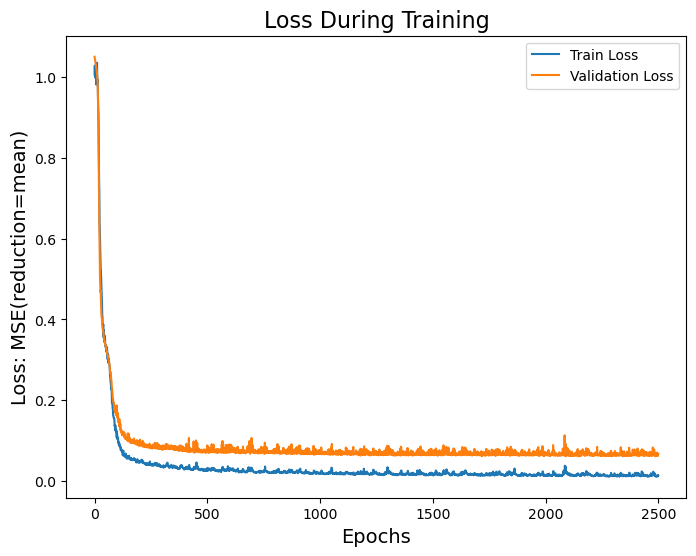

In [7]:
if __name__ == '__main__':
    torch.manual_seed(137)
    
    # Load in the provided data
    train_data = np.load('train_data.npy')
    print(train_data.shape)
    validation_data = np.load('validation_data.npy')
    test_data = np.load('test_data.npy')

    model = NeuralNetwork()
    
    trained_model = train(model, train_data, validation_data)
    evaluate(trained_model, test_data)

    # Load training data and call the provided plot function. Loss function and reduction scheme are
    # required for the plotting function.
    train_losses = np.load("./train_losses.npy")
    val_losses = np.load("./val_losses.npy")

    plot_training_curves(train_losses, val_losses, "MSE", "mean")